## Auto Encoders

At it's core, an autoencoder is a function that takes complex inputs and performs a dimensionality reduction of the data.  Principal Component Analysis is an example of a classical encoding algorithm.  Even a simple linear regression in 2D can serve as an encoder, since you map 2 dimensions (x and y) into just one dimension (position along a line).

An important feature of autoencoders is the ability to reconstruct the input data from the compressed feature representation.  It's easy to see how this is done when you have used PCA or linear regression, but it is more complex with a neural network.

One advantage of using neural networks as auto-encoders is that they have capacity to encode complex data, and the training regime for encoding is not overly complex and similar for many types of data.

In this notebook, we will build an autoencoder for handwritten digits between 0 and 99, inclusive, generated via the mnist dataset.

In [1]:
# Load the data generator and tensorflow:

import tensorflow as tf
import numpy
import random
tf.enable_eager_execution()
from src.utils import data_generator

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import display, clear_output




### Preliminary: data loading pipeline

We're doing something a little unorthodox to make this interesting, which is doing MNIST on digits from 0 to 99, not 0 to 9.  Here is a short class that can handle the data loading for this:

In [2]:
class mnist_generator(object):
    '''
    This class takes the mnist dataset and generates multi-digit examples.
    The goal here is to create on-the-fly augmented data that is more complex
    than just 0 to 9, but also very easy to get access to.
    '''
    
    def __init__(self, seed=0):
        # Use TF to get the dataset, will download if needed.
        (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
        x_train = x_train.astype(numpy.float32) * (1./256)
        x_test  = x_test.astype(numpy.float32) * (1./256)

        self._x_train_base = x_train
        self._y_train_base = y_train        
        self._x_test_base  = x_test
        self._y_test_base  = y_test        
        
        self._base_shape = [28,28]
        
        self._random = random.Random(seed)
        
    def next_train_batch(self, batch_size=10, n_digits=2):
        '''
        Create a new training batch of a specified number of images,
        with the specified number of digits per image.
        
        Parameters
        ----------
        batch_size : int (default = 10)
        n_digits : int (default = 2)
        Returns
        -------
        images : ndarray (shape = [batch_size, 28, n_digits*28]
        labels : ndarray (shape = [batch_size] )

        Examples
        --------
        # Get a batch with 10 images, each a 2 digit number (Default):
        images, labels = generator.next_train_batch()
        
        # Get a batch with 20 images, each a 3 digit number:
        images, labels = generator.next_train_batch(20, 3)
        '''
        
        # First, allocate memory to hold the output data:
        # Data is stored as [B, H, W, C]

        images = numpy.zeros([batch_size, self._base_shape[0], n_digits*self._base_shape[1], 1])
        labels = numpy.zeros([batch_size], dtype=numpy.int32)
        
        indexes = numpy.asarray(
            self._random.sample(
                range(len(self._x_train_base)),
                batch_size*n_digits
            )
        )

        indexes = indexes.reshape([batch_size, n_digits])
        dims = [10] * n_digits
        for b in range(batch_size):
            # pick a random number from the train set:

            for n in range(n_digits):
                i = indexes[b][n]
                images[b, :, n*28:(n+1)*28, 0] = self._x_train_base[i]
                
            this_label = [ self._y_train_base[j] for j in indexes[b] ]
            labels[b] = numpy.ravel_multi_index(this_label, dims)
                
        return images, labels

                

    def next_test_batch(self, batch_size=10, n_digits=2):
        '''
        Create a new testing batch of a specified number of images,
        with the specified number of digits per image.
        
        Parameters
        ----------
        batch_size : int (default = 10)
        n_digits : int (default = 2)
        Returns
        -------
        images : ndarray (shape = [batch_size, 28, n_digits*28]
        labels : ndarray (shape = [batch_size] )

        Examples
        --------
        # Get a batch with 10 images, each a 2 digit number (Default):
        images, labels = generator.next_train_batch()
        
        # Get a batch with 20 images, each a 3 digit number:
        images, labels = generator.next_train_batch(20, 3)
        '''
        
        # First, allocate memory to hold the output data:
        # Data is stored as [B, H, W, C]

        images = numpy.zeros([batch_size, self._base_shape[0], n_digits*self._base_shape[1], 1])
        labels = numpy.zeros([batch_size], dtype=numpy.int32)
        
        indexes = numpy.asarray(
            self._random.sample(
                range(len(self._x_test_base)),
                batch_size*n_digits
            )
        )

        indexes = indexes.reshape([batch_size, n_digits])
        dims = [10] * n_digits
        for b in range(batch_size):
            # pick a random number from the train set:

            for n in range(n_digits):
                i = indexes[b][n]
                images[b, :, n*28:(n+1)*28, 0] = self._x_test_base[i]
                
            this_label = [ self._y_test_base[j] for j in indexes[b] ]
            labels[b] = numpy.ravel_multi_index(this_label, dims)
                
        return images, labels


                

In [3]:
# Calling "next_train_batch" will let you get a batch of data:
generator = mnist_generator()
batch_size = 4
n_digits   = 2
images, labels = generator.next_train_batch(batch_size, n_digits)

(4, 28, 56, 1)


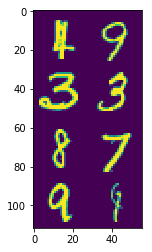

In [4]:
print(images.shape)

# matplotlib can't show a 4D tensor as a 2D image natively.  
# So reshape it into a 2D image:

images_reshape = images.reshape(28*batch_size, 28*n_digits)
plt.imshow(images_reshape)

Does this image match the labels generated?


In [5]:
print(labels)

[49 33 87 94]


Looks good!  Ok, let's build our autoencoder models

### Part 1: Build our models

We'll build two autoencoder models, one with a classic neural network and one with a convolutional neural network.  We'll map both down to the same intermediate representation.

Our decoder stages will be built on the same core operations as the encoders but in reverse.

#### Feed Forward NN encoder (no convolutions)

In [6]:

class Encoder(tf.keras.models.Model):
    '''
    Simple autoencoder forward model
    '''
    
    def __init__(self, num_digits=2, activation=tf.nn.relu, latent_size=10):
        '''
        Create a new instance of an encoder for mnist
        with the specified number of digits per image and .
        
        Parameters
        ----------
        num_digits : int (default = 2)
        activation : tf callable (default = tf.nn.relu)
        latent_size: int (default 10)

        latent_size will determine the size of the encoded space per digit.

        '''
        tf.keras.models.Model.__init__(self)
        self._latent_size = latent_size
        self._num_digits = num_digits
        


        self.encoder_layer_1 = tf.keras.layers.Dense(
            units = 784, 
            activation=activation,
        )
        self.encoder_layer_2 = tf.keras.layers.Dense(
            units = 392,
            activation = activation,
        )
        self.encoder_layer_3 = tf.keras.layers.Dense(
            units = 98,
            activation = activation,
        )
        
        self.final_encoding_layer = tf.keras.layers.Dense(
            units = self._latent_size,
            activation = None,
        )
        
    def call(self, inputs):
        
        # We expect input in [B, H, W, C] format, but the dense model will need to flatten images:
        x = tf.reshape(inputs, [inputs.shape[0], numpy.prod(inputs.shape[1:])  ]  )

        x = self.encoder_layer_1(x)
        x = self.encoder_layer_2(x)
        x = self.encoder_layer_3(x)
        return self.final_encoding_layer(x)

In [7]:

class Decoder(tf.keras.models.Model):
    
    def __init__(self, num_digits = 2,  activation=tf.nn.relu,):
        '''
        Create a new instance of an encoder for mnist
        with the specified number of digits per image and .
        
        Parameters
        ----------
        num_digits : int (default = 2)
        activation : tf callable (default = tf.nn.relu)

        '''
        tf.keras.models.Model.__init__(self)
        self._num_digits = num_digits


        self.decoder_layer_1 = tf.keras.layers.Dense(
            units = 98, 
            activation=activation,
        )
        self.decoder_layer_2 = tf.keras.layers.Dense(
            units = 392,
            activation = activation,
        )
        self.decoder_layer_3 = tf.keras.layers.Dense(
            units = 784,
            activation = activation,
        )
        
        self.final_decoding_layer = tf.keras.layers.Dense(
            units = num_digits*784,
        )
        
    def call(self, inputs ):
        
        batch_size = inputs.shape[0]

        x = self.decoder_layer_1(inputs)
        x = self.decoder_layer_2(x)
        x = self.decoder_layer_3(x)
        x = self.final_decoding_layer(x)
        
        # We apply a sigmoid function to map the output image to the range [0, 1]
        x = tf.nn.sigmoid(x)
            
        # Reshape to have the [B, H, W, C] shape:
        x = tf.reshape(x, [batch_size, 28, self._num_digits*28, 1])
        
        
        return x

In [8]:
# Let's create instance of our models:
encoder = Encoder()
decoder = Decoder()

In [9]:
# Load some data:
batch_images, batch_labels = generator.next_train_batch(batch_size=1)
# Reshape the data:

# batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])

intermediate_state = encoder(batch_images)
decoded_images = decoder(intermediate_state)

In that previous block, we ran a forward pass on both the encoder and the decoder, and had an intermediate output along the way.  Let's look at the network parameters and the untrained output:

In [10]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  1230096   
_________________________________________________________________
dense_1 (Dense)              multiple                  307720    
_________________________________________________________________
dense_2 (Dense)              multiple                  38514     
_________________________________________________________________
dense_3 (Dense)              multiple                  990       
Total params: 1,577,320
Trainable params: 1,577,320
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
#And here is the decoder:
print(decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              multiple                  1078      
_________________________________________________________________
dense_5 (Dense)              multiple                  38808     
_________________________________________________________________
dense_6 (Dense)              multiple                  308112    
_________________________________________________________________
dense_7 (Dense)              multiple                  1230880   
Total params: 1,578,878
Trainable params: 1,578,878
Non-trainable params: 0
_________________________________________________________________
None


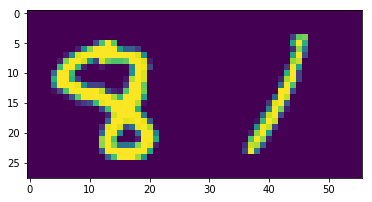

In [12]:
# Let's display the input images:
batch_images_reshape = batch_images.reshape(28*1, 28*2)
plt.imshow(batch_images_reshape)

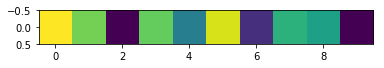

In [13]:
# And the intermediate state:
# batch_images_reshape = batch_images.reshape(28*1, 28*2)
plt.imshow(intermediate_state)

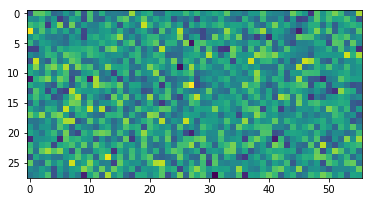

In [14]:
# And here is the output image:
decoded_images_reshape = decoded_images.numpy().reshape(28*1, 28*2)
plt.imshow(decoded_images_reshape)

As you might expect, the output is garbage initially.  No surprises there, the models are completely untrained.

## Training an autoencoder

With a trained encoder/decoder pair, we want the input image to be as close as possible to the output image.  The loss for this network, then, can be constructed as just the mean-square-error of input to output.  We will train this with an AdamOptimizer.

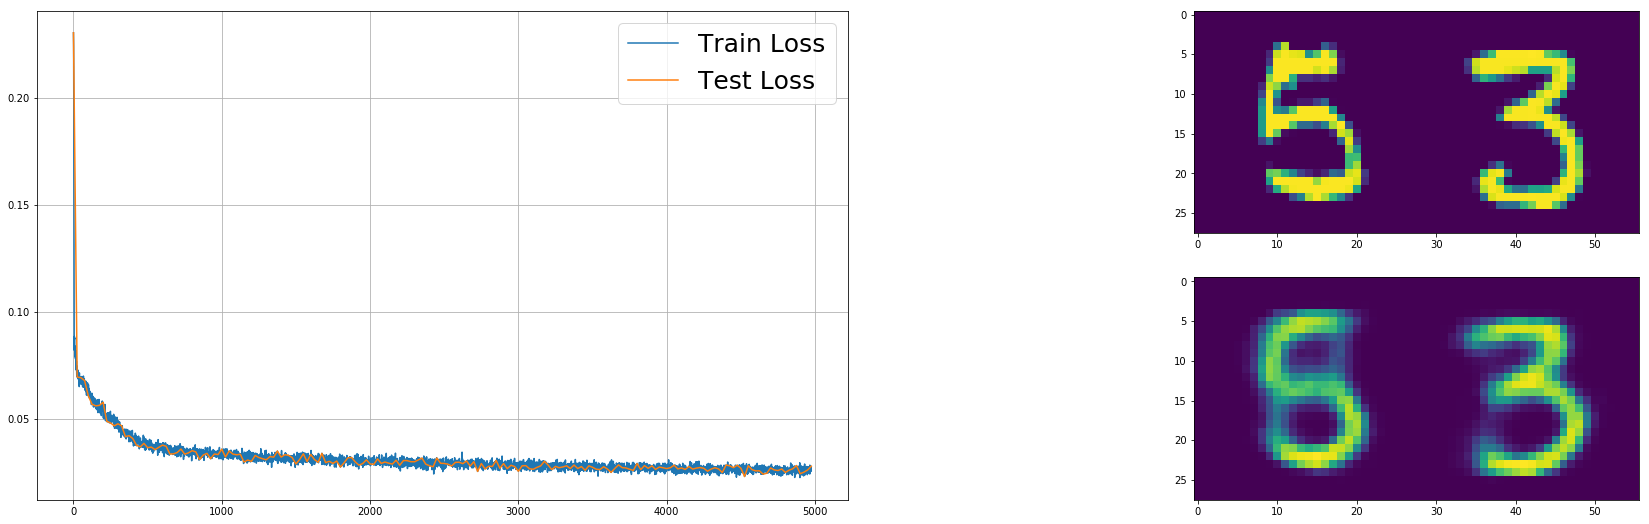

In [15]:
optimizer = tf.train.AdamOptimizer()

# We will keep track of loss along the way:
steps = []
loss_history = []
val_loss_history = []
val_steps = []

# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(32,9))
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_input  = plt.subplot(gs[0,1])
ax_output = plt.subplot(gs[1,1])



NUM_DIGITS=2
BATCH_SIZE=64
N_TRAINING_ITERATION=5000


for i in range(N_TRAINING_ITERATION):

    # Load some data:
    batch_images, batch_labels = generator.next_train_batch(BATCH_SIZE, NUM_DIGITS)
    # Reshape the data:
#     batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
    with tf.GradientTape() as tape:
        intermediate_state = encoder(batch_images)
        decoded_images = decoder(intermediate_state)
        loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)

    if i % 25 == 0:
        test_images, test_labels = generator.next_test_batch(BATCH_SIZE, NUM_DIGITS)
        test_images = test_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
        val_intermediate_state = encoder(test_images)
        val_decoded_images = decoder(intermediate_state)
        val_loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)
        val_loss_history.append(val_loss_value.numpy())
        val_steps.append(i)

        # Here we update the plots.  Replot the loss, and show the latest input and output images
        ax_loss.set_xlim(0, 1.1*i)
        ax_loss.cla()
        ax_loss.plot(steps, loss_history, label="Train Loss")
        ax_loss.plot(val_steps, val_loss_history, label="Test Loss")
        ax_loss.grid(True)
        ax_loss.legend(fontsize=25)
        
        # Display an input image:
        ax_input.imshow(batch_images[0].reshape(28, 28*NUM_DIGITS),vmin=0, vmax=1)
        
        # Display an output image:
        ax_output.imshow(decoded_images.numpy()[0].reshape(28, 28*NUM_DIGITS),vmin=0, vmax=1)
        
        display(fig)
        clear_output(wait = True)
        plt.pause(0.25)

    # Collect the trainable variables as the union of the encoder and decoder variables:
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables

    
    # Update the loss history:
    loss_history.append(loss_value.numpy())
    steps.append(i)
    

    # Apply the update to the model:
    grads = tape.gradient(loss_value, trainable_vars)
    optimizer.apply_gradients(zip(grads, trainable_vars),
                             global_step=tf.train.get_or_create_global_step())



On my laptop, 5000 iterations took 5 or 10 minutues to train (on the CPU). So you should get to good results without too much delay. The plot should update as it is training above.

This is reasonable behavior for a loss function, the loss decreases rapidly at first and then slows.

Next let's compare the original images, intermediate representations, and output images. We can evaluate this for both the input and the test set.

In [16]:
def run_inference(_encoder, _decoder, input_images):
    '''
    This function will make running inference throught the autoencoder easy.
    '''
    N_INFERENCE_IMAGES = input_images.shape[0]
    input_images = input_images.reshape(N_INFERENCE_IMAGES, 
                                        NUM_DIGITS*28*28)


    intermediate_rep = _encoder(input_images)
    decoded_images = _decoder(intermediate_rep)
    decoded_images = decoded_images.numpy().reshape(
        N_INFERENCE_IMAGES*28, NUM_DIGITS*28)
    
    return intermediate_rep, decoded_images

In [17]:
N_INFERENCE_IMAGES = 2

original_images, labels = generator.next_train_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

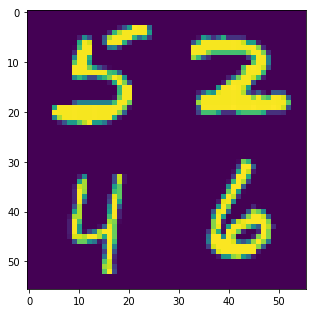

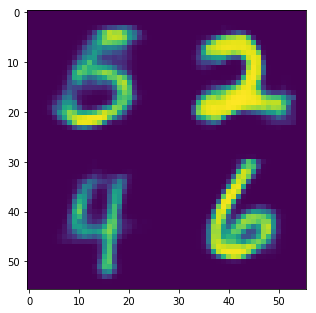

In [18]:
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images)
plt.show()

Well, this is interesting!  The outputs of the autoencoder definitely look like numbers, though not *exactly* the numbers that went into the network.  What does the intermediate representation look like?

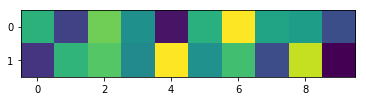

In [19]:
plt.imshow(intermediate_rep)
plt.show()

Can you tell what the numbers are from the intermediate representation?  I certainly can't.  But the decoder can, to a large extent, and that is impressive!

Below, we use the autoencoder on the test dataset, which it has never seen before, to see how well the model generalizes:

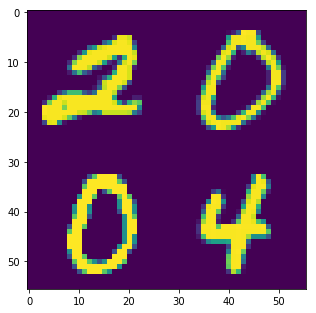

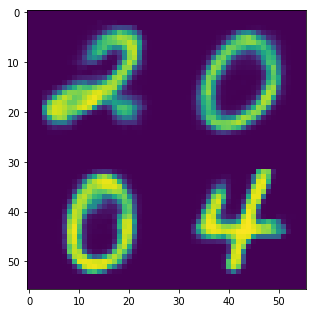

In [245]:
N_INFERENCE_IMAGES = 2


original_images, labels = generator.next_test_batch(
    N_INFERENCE_IMAGES, NUM_DIGITS)

intermediate_rep, decoded_images = run_inference(
    encoder, decoder, original_images)
original_images = original_images.reshape(N_INFERENCE_IMAGES*28, NUM_DIGITS*28)

fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(original_images, vmin=0, vmax=1)
plt.show()
fig = plt.figure(figsize=(5, N_INFERENCE_IMAGES*5))
plt.imshow(decoded_images, vmin=0, vmax=1)
plt.show()

In [24]:
# Before continuing, let's save the models so we can restore them later if we want:
encoder.save_weights("dense_encoder_{}digits.h5".format(NUM_DIGITS))
decoder.save_weights("dense_decoder_{}digits.h5".format(NUM_DIGITS))



## Convolutional Autoencoders

The autoencoder/decoder pair we trained above was using dense, fully connected layers.  In total, each stage had about 1.5 M parameters.  For the mnist problem, this seems hefty: 3M total parameters to compress a dataset of images that are 28x28. We can implement a new encoder/decoder using convolutional neural networks to dramatically reduce the number of parameters needed - can we acheive the same fidelity?

For this section, many of the techniques are identical, but our networks are not.  Let's define them:

In [307]:
class ConvolutionalEncoder(tf.keras.models.Model):
    '''
    Simple autoencoder forward layer
    '''
    
    def __init__(self, num_digits=2, activation=tf.nn.relu, latent_size = 10):
        tf.keras.models.Model.__init__(self)
        self._latent_size = latent_size
        self._num_digits = num_digits

        # Apply a 5x5 kernel to the image:
        self.encoder_layer_1 = tf.keras.layers.Convolution2D(
            kernel_size = [7, 7], 
            filters     = 24,
            padding     = "same",
            activation  = activation,
        )
        
        # Use a 2x2 kernel of stride 2x2 to downsample:
        self.pool_1 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_2 = tf.keras.layers.Convolution2D(
            kernel_size = [7, 7], 
            filters     = 64, 
            padding     = "same",
            activation  = activation,
        )
        self.pool_2 = tf.keras.layers.MaxPool2D()

        self.encoder_layer_3 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 64,
            padding     = "same",
            activation  = activation,
        )
        self.pool_3 = tf.keras.layers.MaxPool2D()

        self.encoder_layer_final = tf.keras.layers.Dense(
            units = latent_size,
            activation = None,
            )
        
        
        


    def call(self, inputs):
        
        batch_size = inputs.shape[0]
        x = inputs
        # Make sure the input is the right shape:
        x = tf.reshape(x, [batch_size, 28, 28*self._num_digits, 1])
            
        x = self.encoder_layer_1(x)
        x = self.pool_1(x)
        x = self.encoder_layer_2(x)
        x = self.pool_2(x)
        x = self.encoder_layer_3(x)
        x = self.pool_3(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.encoder_layer_final(x)

        return tf.reshape(x, [batch_size, self._latent_size])


In [326]:
class ConvolutionalDecoder(tf.keras.models.Model):
    
    def __init__(self, num_digits=2, activation=tf.nn.relu):
        tf.keras.models.Model.__init__(self)

        self._num_digits = num_digits

        # The decoder runs the encoder steps but in reverse.
        
        # The first step is a dense layer to get to the right number of units.
        # It turns out to need to be of shape [3, 3*num_digits + x], where x = floor(num_digits/2)
        self.dense = tf.keras.layers.Dense(
            units = 3 * (3*num_digits + int(num_digits/2))
        )
        
        self.shape0 = [3, (3*num_digits + int(num_digits/2)), 1]
        self.shape1 = [7, 2 * (3*num_digits + int(num_digits/2))]
        
        
        self.decoder_layer_1 = tf.keras.layers.Convolution2D(
            kernel_size = [7, 7],
            filters     = 64,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.contrib.layers.l2_regularizer,
            activation  = activation,
        )
        
        self.unpool_1 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )

        self.decoder_layer_2 = tf.keras.layers.Convolution2D(
            kernel_size = [7, 7],
            filters     = 64,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.contrib.layers.l2_regularizer,
            activation  = activation,
        )
        
        self.unpool_2 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )


        self.decoder_layer_3 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 24,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.contrib.layers.l2_regularizer,
            activation  = activation,
        )
        
        self.decoder_layer_final = tf.keras.layers.Convolution2D(
            kernel_size = [1, 1],
            filters     = 1,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.contrib.layers.l2_regularizer,
            activation  = None,
        )
        

        
    def call(self, inputs):
        ''' 
        Reshape at input and output: 
        '''
            
        
        batch_size = inputs.shape[0]


        x = self.dense(inputs)


        # First Step is to to un-pool the encoded state into the right shape:
        x = tf.reshape(x, [batch_size, self.shape0[0], self.shape0[1], 1])
        x = tf.image.resize_images(
            x,
            size=self.shape1
        )
        
        x = self.decoder_layer_1(x)
        x = self.unpool_1(x)
        x = self.decoder_layer_2(x)
        x = self.unpool_2(x)
        x = self.decoder_layer_3(x)
        x = self.decoder_layer_final(x)
        
        x = tf.reshape(x, [batch_size, 28, self._num_digits*28, 1])
        return x

Ok, now we have defined convolutional autoencoders.  We used a dense layer to map from the final convolutional output to the encoded space (in the encoder), and a similar dense layer to map from encoded space to pre-decoded shape.

Training the convolutional auto encoders is very similar to the fully connected auto encoders.  Let's look at the networks, and go through the training procedure again:

In [327]:
conv_encoder = ConvolutionalEncoder()
conv_decoder = ConvolutionalDecoder()

In [328]:
# Load some data:
batch_images, batch_labels = generator.next_train_batch(batch_size=1, n_digits=2)
# Reshape the data:

# batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])

intermediate_state = conv_encoder(batch_images)
decoded_images = conv_decoder(intermediate_state)

In [329]:
print(conv_encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_322 (Conv2D)          multiple                  624       
_________________________________________________________________
max_pooling2d_171 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_323 (Conv2D)          multiple                  38464     
_________________________________________________________________
max_pooling2d_172 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_324 (Conv2D)          multiple                  102464    
_________________________________________________________________
max_pooling2d_173 (MaxPoolin multiple                  0         
_________________________________________________________________
dense_105 (Dense)            multiple                  13450     
Total para

In [330]:
print(conv_decoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            multiple                  231       
_________________________________________________________________
conv2d_325 (Conv2D)          multiple                  3200      
_________________________________________________________________
up_sampling2d_79 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_326 (Conv2D)          multiple                  200768    
_________________________________________________________________
up_sampling2d_80 (UpSampling multiple                  0         
_________________________________________________________________
conv2d_327 (Conv2D)          multiple                  38424     
_________________________________________________________________
conv2d_328 (Conv2D)          multiple                  25        
Total para

As promised, these networks are nearly 10x smaller in number of parameters.

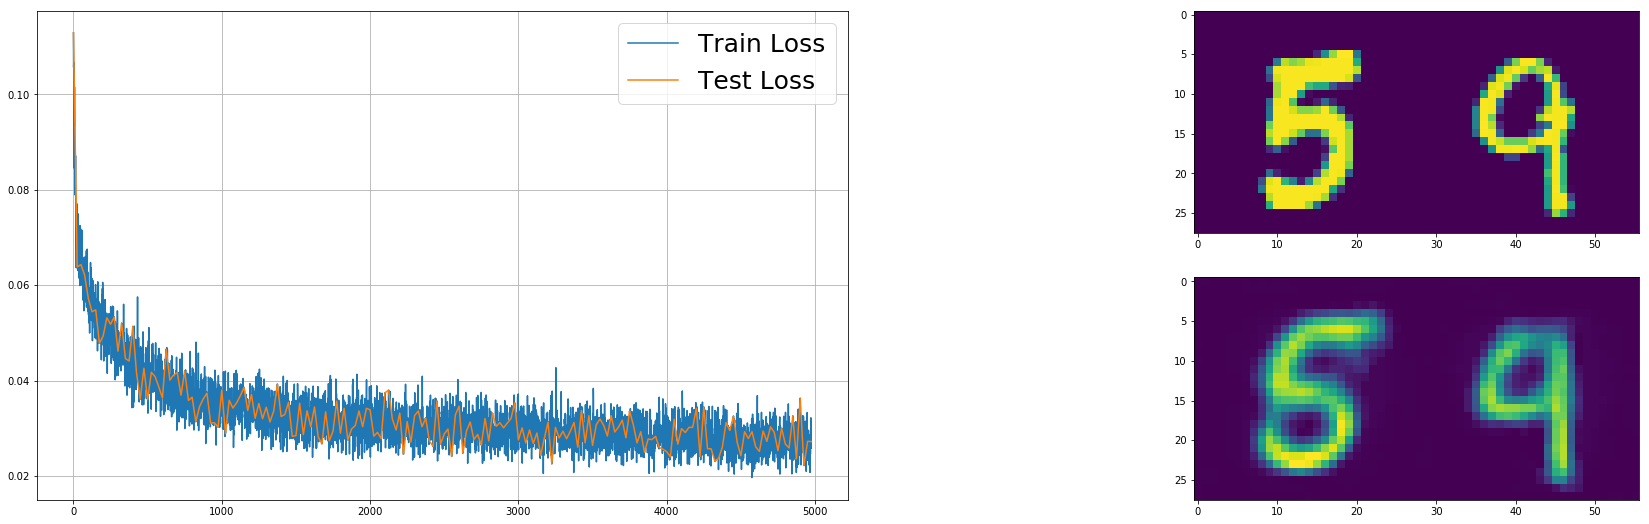

In [331]:
optimizer = tf.train.AdamOptimizer()

# We will keep track of loss along the way:
steps = []
loss_history = []
val_loss_history = []
val_steps = []

# Define a figure here which we can update along the way:
fig       = plt.figure(figsize=(32,9))
# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)
ax_loss   = plt.subplot(gs[:,0])
ax_input  = plt.subplot(gs[0,1])
ax_output = plt.subplot(gs[1,1])



NUM_DIGITS=2
BATCH_SIZE=12
N_TRAINING_ITERATION=5000


for i in range(N_TRAINING_ITERATION):

    # Load some data:
    batch_images, batch_labels = generator.next_train_batch(BATCH_SIZE, NUM_DIGITS)
    # Reshape the data:
#     batch_images = batch_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
    with tf.GradientTape() as tape:
        intermediate_state = conv_encoder(batch_images)
        decoded_images = conv_decoder(intermediate_state)
        loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)
        loss_value += tf.losses.get_regularization_loss()
#         print("Original mean: ", numpy.mean(batch_images))
#         print("Output mean: ", numpy.mean(decoded_images.numpy()))
    if i % 25 == 0:
        test_images, test_labels = generator.next_test_batch(BATCH_SIZE, NUM_DIGITS)
        test_images = test_images.reshape([BATCH_SIZE, 28*28*NUM_DIGITS])
        val_intermediate_state = conv_encoder(test_images)
        val_decoded_images = conv_decoder(intermediate_state)
        val_loss_value = tf.losses.mean_squared_error(batch_images, decoded_images)
        val_loss_history.append(val_loss_value.numpy())
        val_steps.append(i)

        # Here we update the plots.  Replot the loss, and show the latest input and output images
        ax_loss.set_xlim(0, 1.1*i)
        ax_loss.cla()
        ax_loss.plot(steps, loss_history, label="Train Loss")
        ax_loss.plot(val_steps, val_loss_history, label="Test Loss")
        ax_loss.grid(True)
        ax_loss.legend(fontsize=25)
        
        # Display an input image:
        ax_input.imshow(batch_images[0].reshape(28, 28*NUM_DIGITS), vmin=0, vmax=1)
        
        # Display an output image:
        ax_output.imshow(decoded_images.numpy()[0].reshape(28, 28*NUM_DIGITS), vmin=0, vmax=1)
        
        display(fig)
        clear_output(wait = True)
        plt.pause(0.25)

    # Collect the trainable variables as the union of the encoder and decoder variables:
    trainable_vars = conv_encoder.trainable_variables + conv_decoder.trainable_variables

    
    # Update the loss history:
    loss_history.append(loss_value.numpy())
    steps.append(i)
    

    # Apply the update to the model:
    grads = tape.gradient(loss_value, trainable_vars)
    optimizer.apply_gradients(zip(grads, trainable_vars),
                             global_step=tf.train.get_or_create_global_step())




As you see the training progress, you'll notice dramatically different early output is produced as these networks train.  

In [332]:
# Before continuing, let's save the models so we can restore them later if we want:
conv_encoder.save_weights("conv_encoder_{}digits.h5".format(NUM_DIGITS))
conv_decoder.save_weights("conv_decoder_{}digits.h5".format(NUM_DIGITS))

## Comparing Autoencoders

In the previous examples, we trained two autoencoders to compress hand written digits (0 to 99) into a single, 10-long floating point number per digit. The first network was a standard fully connected neural network, and the second was a much smaller convolutional neural network - about 10x smaller in trainable parameters.

Which was better? It's hard to answer that question just from looking at a few output images, and certainly examining the intermediate representation by eye is not useful. Instead we'll try two techniques to measure just "how good" the autoencoder/decoder pairs are doing:

1) Comparision of Mean Squared Error on validation set

2) Comparision of performance of classification network on decoded images

In [335]:
# First, load up the a big mnist validation set:

test_images, test_labels = generator.next_test_batch(batch_size=100, n_digits=2)


In [338]:
dense_intermediate_state = encoder(test_images)
dense_decoded = decoder(dense_intermediate_state)

conv_intermediate_state = conv_encoder(test_images)
conv_decoded = conv_decoder(conv_intermediate_state)

In [339]:
dense_loss = tf.losses.mean_squared_error(test_images, dense_decoded)
conv_loss = tf.losses.mean_squared_error(test_images, conv_decoded)

In [340]:
print("Fully connected test loss: ", dense_loss.numpy())
print("Convolutional test loss: ", conv_loss.numpy())

Fully connected test loss:  0.024658995
Convolutional test loss:  0.026133584


Which is better?  Depending on how the training went, it can be hard to tell.  The pretrained models will tell you that the fully connected model is marginally, but not impactfully, worse.

Let's look at another comparison.  We'll quickly spin up a classifier for mnist digits and then see how well the decoded data is doing at recreating it's original state by classifying the output of the decoder.

Here is an mnist model that can classify the images:

In [364]:
class DigitClassifier(tf.keras.models.Model):
    '''
    Simple mnist N-digit classifier
    '''
    
    def __init__(self, num_digits=2, activation=tf.nn.relu):
        tf.keras.models.Model.__init__(self)
        self._num_digits = num_digits

        # Apply a 5x5 kernel to the image:
        self.encoder_layer_1 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5], 
            filters     = 24,
            padding     = "same",
            activation  = activation,
        )
        
        # Use a 2x2 kernel of stride 2x2 to downsample:
        self.pool_1 = tf.keras.layers.MaxPool2D()
        
        self.encoder_layer_2 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5], 
            filters     = 64, 
            padding     = "same",
            activation  = activation,
        )
        self.pool_2 = tf.keras.layers.MaxPool2D()

        self.encoder_layer_3 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 128,
            padding     = "same",
            activation  = activation,
        )

        self.encoder_layer_final = tf.keras.layers.Convolution2D(
            kernel_size = [1, 1],
            filters     = 10**self._num_digits,
            padding     = "same",
            activation  = None,
        )
        
        self.pool_3 = tf.keras.layers.GlobalAveragePooling2D()


        
        


    def call(self, inputs):
        
        batch_size = inputs.shape[0]
        x = inputs
        # Make sure the input is the right shape:
        x = tf.reshape(x, [batch_size, 28, 28*self._num_digits, 1])
            
        x = self.encoder_layer_1(x)
        x = self.pool_1(x)
        x = self.encoder_layer_2(x)
        x = self.pool_2(x)
        x = self.encoder_layer_3(x)
        x = self.encoder_layer_final(x)
        x = self.pool_3(x)
        return x


In [365]:
classifier = DigitClassifier(2)

In [366]:
example_img, example_label = generator.next_test_batch(1,2)
classifier(example_img)

print(classifier.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_349 (Conv2D)          multiple                  624       
_________________________________________________________________
max_pooling2d_184 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_350 (Conv2D)          multiple                  38464     
_________________________________________________________________
max_pooling2d_185 (MaxPoolin multiple                  0         
_________________________________________________________________
conv2d_351 (Conv2D)          multiple                  204928    
_________________________________________________________________
conv2d_352 (Conv2D)          multiple                  12900     
_________________________________________________________________
global_average_pooling2d_5 ( multiple                  0         
Total para

In [367]:
TRAIN_CLASSIFIER = True
if TRAIN_CLASSIFIER:
    N_TRAINING_ITERATION = 1500
    BATCH_SIZE = 200

    optimizer = tf.train.AdamOptimizer()

    loss_history = []
    val_loss_history = []
    val_steps = []

    for i in range(N_TRAINING_ITERATION):

        # Load some data:
        training_batch_images, training_batch_labels = generator.next_train_batch(BATCH_SIZE, NUM_DIGITS)

        with tf.GradientTape() as tape:
            logits = classifier(training_batch_images)
            loss_value = tf.losses.sparse_softmax_cross_entropy(training_batch_labels, logits)


        trainable_vars = classifier.trainable_variables


        loss_history.append(loss_value.numpy())

        # Apply the update to the model:
        grads = tape.gradient(loss_value, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars),
                                 global_step=tf.train.get_or_create_global_step())

        if i % 5 == 0:
            print("Step {}, loss {}".format(i, loss_history[-1]))
else:
    training_batch_images, training_batch_labels = generator.next_train_batch(1, NUM_DIGITS)
#     logits = model(batch_images.reshape(1, 28, 28, 1))
    classifier.load_weights(MODEL_PREFIX + "mnist_classifier.h5")

Step 0, loss 4.6038312911987305
Step 5, loss 4.61872673034668
Step 10, loss 4.606785774230957
Step 15, loss 4.605005741119385
Step 20, loss 4.60542106628418
Step 25, loss 4.604241371154785
Step 30, loss 4.605370044708252
Step 35, loss 4.602131366729736
Step 40, loss 4.599294662475586
Step 45, loss 4.602619171142578
Step 50, loss 4.597806453704834
Step 55, loss 4.590731620788574
Step 60, loss 4.561397552490234
Step 65, loss 4.531129360198975
Step 70, loss 4.4875006675720215
Step 75, loss 4.369602680206299
Step 80, loss 4.329061985015869
Step 85, loss 4.266436576843262
Step 90, loss 4.073729038238525
Step 95, loss 3.9354870319366455
Step 100, loss 3.9879937171936035
Step 105, loss 3.8632593154907227
Step 110, loss 3.821894645690918
Step 115, loss 3.7812600135803223
Step 120, loss 3.740978956222534
Step 125, loss 3.626908540725708
Step 130, loss 3.536175489425659
Step 135, loss 3.324336051940918
Step 140, loss 3.3042993545532227
Step 145, loss 3.1762964725494385
Step 150, loss 3.066793441

KeyboardInterrupt: 

Ok, let's run this classifier on the test images:

In [371]:
predictions = classifier(test_images)

We have the decoded versions of the validation sets for both the fully connected and convolutional networks.  Let's run our classifier on the original images, the decoded images, and compare the accuracies for both as well as the "recall" ability (as judged by our classifier) to produce the same digit after the encoder/decoder pass:


In [375]:
print("Average accuracy on test set: ", numpy.mean(test_labels == numpy.argmax(predictions,axis=-1)))

Average accuracy on test set:  0.86


Ok, let's encode and decode the test set and see how the accuracy changes:


In [378]:
dense_decoded_test_set = decoder(encoder(test_images))
conv_decoded_test_set  = conv_decoder(conv_encoder(test_images))

In [380]:
dense_decoded_predictions = classifier(dense_decoded_test_set)
conv_decoded_predictions  = classifier(conv_decoded_test_set)

ValueError: Incompatible type conversion requested to type 'float32' for variable of type 'float64'

Based on this, we see that the fully connected encoder is underperforming the convolutional encoder slightly, not just in loss during training but also in ability to reproduce images of the same class.

The two encoders generally produce images that are slightly less easy for the convolutional classifier to identify.  Interestingly, they are given the same category (right or wrong) 96% of the time, and 4% of the time they diverge into a different category.

One outstanding question is: how do we tell if a number is being misclassified because of the encoder or because of the classifier?  Let's compare predictions before and after encoding:

In [386]:
print("Average accuracy on dense-decoded-test set: ", numpy.mean(test_labels == numpy.argmax(dense_decoded_predictions,axis=-1)))

Average accuracy on dense-decoded-test set:  0.76


In [387]:
print("F.C. Agreement before/after encoding: ", numpy.mean(fc_predicted_classes == original_predicted_classes) )
print("Conv. Agreement before/after encoding: ", numpy.mean(conv_predicted_classes == original_predicted_classes) )




NameError: name 'fc_predicted_classes' is not defined

Interest! On the pretrained models at least, the probability that a digit will be classified in the same class it was originally is more than 1% higher.  So here is a metric indicating that for this analysis, faithfully reproducing digits as classified by a neural net, the convolutional network is out performing the fully connected.   Before wrapping up, let's look at some images that are changing categories:

In [388]:
conv_changed_images = conv_predicted_classes != original_predicted_classes
pre_images = x_test[conv_changed_images]

temp = conv_decoded.numpy()
post_images = temp[conv_changed_images]

fig = plt.figure(figsize=(250,100))
image = numpy.zeros((25*28, 2*28))
image[:,0:28] = pre_images[0:25].reshape(25*28, 28)
image[:,28:] = post_images[0:25].reshape(25*28, 28)
plt.imshow(image)
plt.show()

NameError: name 'conv_predicted_classes' is not defined

So, there are 25 examples where the convolutional auto-encoder failed to accurately restore information.  You can see visually it broke down only a little in most of these cases.